# Coding Exercise 2

## The model

- There is only one agent who governs all resource allocations in the economy. She produces a (single) good through a production function:

    $$
    y_{t} = f(k_{t}) \tag{1}
    $$

- The good can be used for consumption and investment. 

- In this exercise, we introduce a partial capital depreciation, i.e. capital depreciates at the rate $0<\delta<1$ each period. Hence the resource constraint for the agent is:

    <a id='constraint'></a>
    $$
    k_{t+1} + c_t = y_t + (1-\delta)k_t \tag{2}
    $$

- The agent wants to maximize

    <a id='lifetime_utility'></a>
    $$
    \mathbb E \left[ \sum_{t = 0}^{\infty} \beta^t u(c_t) \right] \tag{3}
    $$
    subject to [(2)](#constraint), where $ \beta \in (0, 1) $ is a discount factor. 
   
- The model is almost identical to Cass-Koopmans planning model. In order to solve this model, we will apply value function iteration algorithm. Hence, we first reformulate the maximization problem into a Bellman equation. 

### The Bellman Equation

We can write the value function for the agent's utility maximization problem in the form of **Bellman equation**. In this exercise we will use capital ($k$) as state variable instead of output ($y$). The value function is defined as follows:

<a id='value_fn'></a>
$$
v(k) = \max_{0 \leq c \leq y + (1-\delta)k}
    \left\{ u(c) + \beta v(k') \right\} \tag{4}
$$
subject to 
$$
k' = f(k) + (1-\delta)k - c 
$$

This formulation takes consumption ($c$) as control variable. For the computation below we will use the next period capital ($k'$) as control variable. Then [(4)](#value_fn) can be rewritten as follows:

<a id='Bellman_eq'></a>
$$
v(k) = \max_{0 \leq k' \leq y + (1-\delta)k}
    \left\{ u\left(f(k) + (1-\delta)k - k'\right) + \beta v(k') \right\} \tag{5}
$$

Essentially we converted the constrained maximization problem in [(4)](#value_fn) into the unconstrained maximization problem in [(5)](#Bellman_eq).

## Question 1: Computation with Value Function Iteration

Let's solve for the value function and the optimal policy through the value function iteration method. The algorith is similar to that in the lecture. But the algorithm should be much simpler since no uncertainty is involved in this exercise. No need to compute the Monte Carlo integration here. Due to partial capital depreciation, the value function and the optimal policy function do not allow for analytic form in this exercise.

1. jit-compile codes using `numba` package.
1. `brent_max` will be used to find the optimal policy for each state. 
1. `interpolation.interp` will be used to evaluate the value function at an off-grid point.

### Q.1-0: Import necessary packages.

In [4]:
# your code here
# import all packages that you need
from numba import njit, int64, float64
from numba.experimental import jitclass
from quantecon.optimize.scalar_maximization import brent_max
from interpolation import interp
import numpy as np

### Q.1-1: Define the class for the model economy

Write a class **OptimalGrowth** that specifies the following.

- discount factor: $\beta = 0.96$
- uility function: $\frac{c^{1-\gamma}}{1-\gamma}$ with $\gamma=2$
- production function: $f(k) = k^\alpha$ with $\alpha = 0.4$
- capital depreciation rate: $\delta=0.1$
- grid vector for the state variable: $k \in [0.1, 10]$ with grid_size = 500
- collect the model parameters and declare their types in **opt_growth_data**
- jit-compile the class with `@jitclass`

The contents of the class should be very similar to those from the lecture.

In [5]:
# your code here
opt_growth_data = [
    ('beta', float64),
    ('gamma', int64),
    ('alpha', float64),
    ('delta', float64),
    ('grid', float64[:]),
]
@jitclass(opt_growth_data)
class OptimalGrowth:
    def __init__(self, 
                 beta=0.96,
                 gamma=2,
                 alpha=0.4,
                 delta=0.1,
                 gridsize=500):
        self.beta = beta
        self.gamma = gamma
        self.alpha = alpha
        self.delta = delta
        self.grid = np.linspace(0.1, 10, gridsize)
    
    def u(self, c):
        return (c**(1-self.gamma))/(1-self.gamma)

    def f(self, k):
        return k**self.alpha
    
    def objective(self, k_, k, v):
        c = self.f(k) + (1 - self.delta) * k - k_
        v_itp = lambda x: interp(self.grid, v, x)
        out = self.u(c) + self.beta * v_itp(k_)
        
        return out

### Q.1-2: Define the Bellman Operator

Write a function that defines the right-hand side of the Bellman equation.

- function head: **T(v, og_VI)** 
- `v` is the vector of value function in the current iteration.
- `og_VI` is the instance of the class `OptimalGrowth_VI` to be initiated later.
- solve the maximization problem using `brent_max` function. You may refer to [this site](https://quanteconpy.readthedocs.io/en/latest/optimize/scalar_maximization.html) to find the usage of `brent_max`.
- use `brent_max` function with caution in setting the range of $k'$ to make sure consumption nonnegative.
- update the value function `v_new` and the optimal policy function `v_greedy`.
- jit-compile the function with `@njit`

In [6]:
# your code here
@njit
def T(v, og_VI):
    # RHS of the Bellman equation
    v_new = np.zeros_like(v) # new value function
    v_greedy = v_new.copy() # optimal policy function
    
    for i in range(len(og_VI.grid)):
        k = og_VI.grid[i]
        upper_bound = og_VI.f(k) + ((1 - og_VI.delta) * k)
        v_greedy[i], v_new[i], _ = brent_max(og_VI.objective, a=0, b=upper_bound, args=(k, v))
    
    return v_new, v_greedy

### Q.1-3: Implement the Value Function Iteration

Write a function that iterates the Bellman operator until the value function converges. 

- function head: `solve_model_VI(og_VI, tol=1e-4, max_iter=1000, print_skip=20)`
- the arguements are analogous to those in the lecture.
- use the grid vector for the state variable itself as the initial guess for the value function.
- while iterating, the function should show the progress every 20 iteration.
- the function should return the converged value function and the accompanying greedy function.

In [7]:
# your code here
def solve_model_VI(og_VI, tol=1e-4, max_iter=1000, print_skip=20):
    v = og_VI.grid.copy()
    i = 0
    while i < max_iter:
        value, policy = T(v, og_VI)
        error = np.max(np.abs(v - value)) # Supremum norm
        if error < tol:
            print('Early stopping due to tolerance')
            print('Curr iter: {:-4} / {}'.format(i, max_iter), '| Error: %.4f' % error)
            break
        if i % print_skip == 0: 
            print('Curr iter: {:-4} / {}'.format(i, max_iter), '| Error: %.4f' % error)
        i += 1
        v = value # update value
    return value, policy

### Q.1-4: Run the Value function iteration

- create an instance of the class OptimalGrowth_VI `og_VI` with the default parameter values defined in the class.
- run `solve_model_VI`.
- using the converged policy function `k_opt_VI`, compute the optimal consumption with respect to capital `c_opt_VI`. 
- plot figures for the converged value function, the policy function and the consumption function.


In [8]:
# your code here
og_VI = OptimalGrowth()
value, policy = solve_model_VI(og_VI)

Curr iter:    0 / 1000 | Error: 2.0527
Curr iter:   20 / 1000 | Error: 0.4572
Curr iter:   40 / 1000 | Error: 0.1953
Curr iter:   60 / 1000 | Error: 0.0853
Curr iter:   80 / 1000 | Error: 0.0376
Curr iter:  100 / 1000 | Error: 0.0166
Curr iter:  120 / 1000 | Error: 0.0073
Curr iter:  140 / 1000 | Error: 0.0032
Curr iter:  160 / 1000 | Error: 0.0014
Curr iter:  180 / 1000 | Error: 0.0006
Curr iter:  200 / 1000 | Error: 0.0003
Curr iter:  220 / 1000 | Error: 0.0001
Early stopping due to tolerance
Curr iter:  226 / 1000 | Error: 0.0001


### Q.1-5: Compute the time-series of capital and consumption

Suppose that the agent is endowed with $k_0$ at the very first period of her life. Each period, she chooses $k_{t+1}$, equivalently $c_t$, according to the policy function computed above. We want to compute the time-series of $k_t$ and $c_t$ thoughout her life using the optimal policy functions computed above.

Write a function that simulates the capital and consumption of the agent. This function will be used again for the time iteration algorithm below.

- function head: Simulate_Time_Series(T, k0, og, k_opt, c_opt)
    - `T`: length of time-series
    - `k0`: initial capital holdings
    - `og`: model
    - `k_opt`: converged policy function for $k'$ 
    - `c_opt`: policy function for $c$ 
- need to interpolate policy functions
- compute and plot the time-series $\{k_t, c_t\}$ for $t=0, 1, \cdots T$.


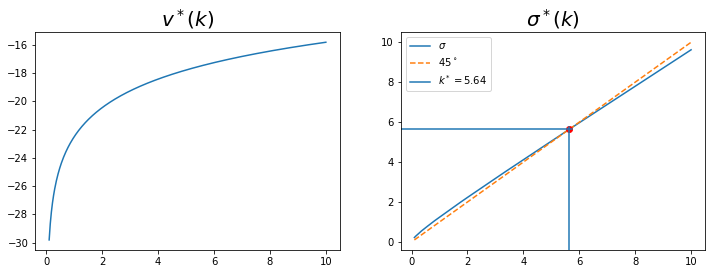

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(og_VI.grid, value)
ax[0].set_title(r"$v^*(k)$", fontsize=20)
ax[1].plot(og_VI.grid, policy, label=r'$\sigma$')
ax[1].plot(og_VI.grid, og_VI.grid, '--', label=r'$45^\circ$')
ax[1].set_title(r"$\sigma^*(k)$", fontsize=20)
idx = np.argwhere(np.diff(np.sign(policy - og_VI.grid))).flatten()
k_star = og_VI.grid[idx]
ax[1].plot(og_VI.grid[idx], policy[idx], 'ro')
ax[1].axvline(x=k_star, ymax=k_star/10, label=r"$k^*=%.2f$"%k_star)
ax[1].axhline(y=k_star, xmax=k_star/10)
plt.legend(fontsize=10)
plt.show()

In [10]:
# your code here
from typing import Callable

def Simulate_Time_Series(T: int, 
                         k0: float,
                         og: OptimalGrowth,
                         k_opt: Callable,
                         c_opt: Callable):
    k = k_opt(k0)
    c = c_opt(k0)
    out = {'k': [k], 'c': [c]}

    for i in range(T-1):
        k_ = k_opt(k)
        c = c_opt(k)
        out['k'].append(k_)
        out['c'].append(c)
        k = k_
        
    return out

### Q.1-6: Generate and plot the time series of capital and consumption

Generate and plot `k_path_VI` and `c_path_VI` for $t=0, 1, \cdots, 100$ with $k_0 = 1$.

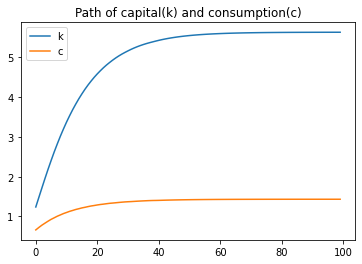

In [11]:
# your code here

# Define policy function with interpolation
k_opt = lambda x: interp(og_VI.grid, policy, x)
c_opt = lambda x: og_VI.f(x) + (1-og_VI.delta) * x - k_opt(x)

# Generate path
result = Simulate_Time_Series(100, 1, og_VI, k_opt, c_opt)

# Plot the result
k_path_VI, c_path_VI = result.values()
plt.plot(k_path_VI, label='k')
plt.plot(c_path_VI, label='c')
# plt.plot(np.array(k_path_VI) + np.array(c_path_VI), label='y')
plt.title('Path of capital(k) and consumption(c)')
plt.legend()
plt.show()

## Question 2: Computation with Time Iteration

Now we will solve the above model with a different computation algorithm, time iteration by Coleman. The utility and production functions satisfy all assumptions for the value function to be strictly concave, increasing and continuously differentiable. Hence the first-order conditions for the maximization yield the **Euler equation** as follows:

$$
u' (c) = \beta u'(c') [f'(k') + 1 - \delta]
$$

Equivalently, using the resource constraint, it can be written as:

$$
u' \left( f(k) + (1-\delta)k - k' \right) = \beta u' \left( f(k') + (1-\delta)k' - k'' \right) \left[ f'(k') + 1 - \delta \right]
$$

This Euler equation takes the form of the second order deffference equation, which is difficult to solve for. However, the essence of the time iteration algorithm is to find the fixed point of the policy function, $k' = \sigma^*(k)$, through iterating the Coleman operator $K\sigma$ that is defined:

<a id='euler_eq'></a>
$$
u' \left( f(k) + (1-\delta)k - k' \right) = \beta u' \left( f(k') + (1-\delta)k' - \sigma(k') \right) \left[ f'(k') + 1 - \delta \right] \tag{6}
$$


### Q.2-1: Define the new class for the Time Iteration

- class name: **OptimalGrowth_TI**
- use the same parameter values as in the previous class **OptimalGrowth_VI**.
- use the same production and utility functions as in **OptimalGrowth_VI**.
- define functions for the derives of production and utility functions.
- define a function for the Euler equation.
- collect the model parameters and declare their types in **opt_growth_data**.
- jit-compile the class with `@jitclass`


In [12]:
# your code here

opt_growth_data = [
    ('beta', float64),
    ('gamma', int64),
    ('alpha', float64),
    ('delta', float64),
    ('grid', float64[:]),
]

@jitclass(opt_growth_data)
class OptimalGrowth_TI:
    def __init__(self, 
                 beta=0.96,
                 gamma=2,
                 alpha=0.4,
                 delta=0.1,
                 gridsize=500):
        self.beta = beta
        self.gamma = gamma
        self.alpha = alpha
        self.delta = delta
        self.grid = np.linspace(0.1, 10, gridsize)
    
    def u(self, c):
        return (c**(1-self.gamma))/(1-self.gamma)
    
    def u_(self, c):
        if c == 0:
            c = 1e-10
        return c**(-self.gamma)

    def f(self, k):
        return k**self.alpha
    
    def f_(self, k):
        return self.alpha * (k ** (self.alpha-1))
    
    def euler_diff(self, k_, k, policy_vec):
        # 𝑢′(𝑐)=𝛽𝑢′(𝑐′)[𝑓′(𝑘′)+1−𝛿]
        # 𝑢′(𝑓(𝑘)+(1−𝛿)𝑘−𝑘′)=𝛽𝑢′(𝑓(𝑘′)+(1−𝛿)𝑘′−𝑘″)[𝑓′(𝑘′)+1−𝛿]
        # 𝑢′(𝑓(𝑘)+(1−𝛿)𝑘−𝑘′)=𝛽𝑢′(𝑓(𝑘′)+(1−𝛿)𝑘′−𝜎(𝑘′))[𝑓′(𝑘′)+1−𝛿]
        
        policy = lambda x: interp(self.grid, policy_vec, x)
        c = self.f(k) + (1 - self.delta) * k - k_
        c_ = self.f(k_) + (1 - self.delta) * k_ - policy(k_)
        val = self.u_(c_) * (self.f_(k_) + 1 - self.delta)
        out = self.u_(c) - (self.beta * val)
        
        return out

### Q.2-2: Define the Coleman operator

Write a function that defines the Coleman operator $K$ that updates the optimal policy function $\sigma$ by solving the (nonlinear) Equler equation for the optimal $k'$. The contents of the function should be very similar to those of `T`, the Bellman operator for the value function iteration algorithm. 

- function head: **K($\sigma$, og_TI)**
- $\sigma$ is the vector of optimal policy for $k'$ in the current iteration.
- `og_TI` is the instance of the class OptimalGrowth_TI to be initiated later.
- solve the nonlinear euqation for $k'$ for each grid of $k$ using `brentq` function. You may refer to [this site](https://quanteconpy.readthedocs.io/en/latest/optimize/root_finding.html) to find the usage of `brentq`.
- update the policy value function $\sigma_{new}$.
- jit-compile the function with @njit
- need to import `brentq`:

In [13]:
from quantecon.optimize.root_finding import brentq

- code for the function **K($\sigma$, og_TI)** below:

In [14]:
# your code here
@njit
def K(policy: np.ndarray , og_TI: OptimalGrowth_TI):
    policy_ = np.empty_like(policy)
    for i, k in enumerate(og_TI.grid):
        upper_bound = og_TI.f(k) + ((1 - og_TI.delta) * k)
        results = brentq(og_TI.euler_diff, 1e-10, upper_bound-1e-10, args=(k, policy))
        policy_[i] = results[0]
    
    return policy_

### Q.2-3: Implement the Time Iteration

Write a function that iterates the Coleman operator until the policy function converges. 

- function head: `solve_model_TI(og_TI, tol=1e-4, max_iter=1000, print_skip=5)`
- the contents of the function are similar to those in the previous `solve_model_VI`.

In [15]:
# your code here

def solve_model_TI(og_TI, tol=1e-4, max_iter=1000, print_skip=5):
    policy = og_TI.grid.copy()
    i = 0

    while i < max_iter:
        policy_ = K(policy, og_TI)
        error = np.max(np.abs(policy - policy_))
        i += 1
        
        if error < tol:
            print('Early stopping due to tolerance')
            print('Curr iter: {:-4} / {}'.format(i, max_iter), '| Error: %.4f' % error)
            break
        
        if i % print_skip == 0: 
            print('Curr iter: {:-4} / {}'.format(i, max_iter), '| Error: %.4f' % error)
        
        i += 1
        policy = policy_
        
    return policy_

### Q.2-4: Run the Time Iteration

- create an instance of the class OptimalGrowth `og_TI` with the default parameter values defined in the class.
- run `solve_model_TI`.
- using the converged policy function `k_opt_TI`, compute the optimal consumption with respect to capital `c_opt_TI`. 
- plot figures for the converged policy function and the consumption function.
- compute the steady state capital $k^*$ such that $k^*=k'(k^*)$ which is the solution to $1 = \beta \left(f'(k^*) + 1- \delta \right)$. 
- add a 45 degree line on the figure for the policy function to identify the steady state capital.
- put a mark at the coordinate of the steady state in the figure for the policy function.

Curr iter:    5 / 1000 | Error: 0.0324
Curr iter:   15 / 1000 | Error: 0.0240
Curr iter:   25 / 1000 | Error: 0.0129
Curr iter:   35 / 1000 | Error: 0.0053
Curr iter:   45 / 1000 | Error: 0.0020
Curr iter:   55 / 1000 | Error: 0.0007
Curr iter:   65 / 1000 | Error: 0.0002
Early stopping due to tolerance
Curr iter:   75 / 1000 | Error: 0.0001


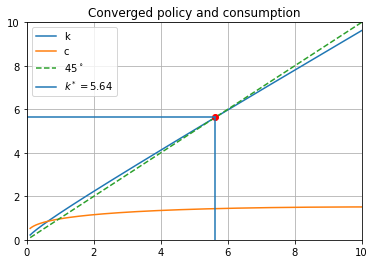

In [16]:
# your code here

# Instantiate OptimalGrowth_TI
og_TI = OptimalGrowth_TI()

# Run solve_model_TI
k_opt_TI = solve_model_TI(og_TI)

# Compute the optimal consumption
c_opt_TI = og_TI.f(k_opt_TI) + (1-og_TI.delta) * k_opt_TI - k_opt_TI

# Plot the policy and consumption function
plt.figure(figsize=(6,4))
plt.plot(og_TI.grid, k_opt_TI, label='k')
plt.plot(og_TI.grid, c_opt_TI, label='c')
# plt.plot(og_TI.grid, k_opt_TI + c_opt_TI, label='y')
plt.xlim([0,10])
plt.ylim([0,10])
plt.plot(og_TI.grid, og_TI.grid, '--', label=r'$45^\circ$')
plt.title('Converged policy and consumption')

# Compute the steady state capital
idx = np.argwhere(np.diff(np.sign(k_opt_TI - og_TI.grid))).flatten()
k_star = og_TI.grid[idx]
plt.plot(og_TI.grid[idx], k_opt_TI[idx], 'ro')
plt.axvline(x=k_star, ymax=k_star/10, label=r"$k^*=%.2f$"%k_star)
plt.axhline(y=k_star, xmax=k_star/10)
plt.legend(fontsize=10)
plt.grid()
plt.show()

### Q.2-5: Generate and plot the time-series of capital and consumption

- Generate and plot `k_path_TI` and `c_path_TI` for $t=0, 1, \cdots, 100$ with $k_0 = 1$.
- You should get the identical figures for `k_path_TI` and `c_path_TI` as `k_path_VI` and `c_path_VI` in Q.1-6.
- You don't need to write a fucntion to generate the time-series, but you can just use `Simulate_Time_Series` function that you defined for Q.1-5.

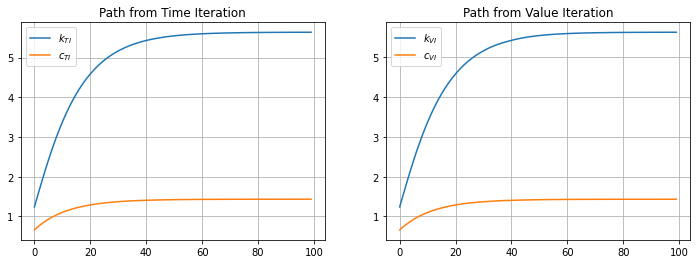

Mean Squared Error btw path k from TI and VI: 0.0000
Mean Squared Error btw path c from TI and VI: 0.0000
The paths from TI and VI are identical


In [17]:
# your code here
# Define policy function with interpolation
k_opt = lambda x: interp(og_TI.grid, k_opt_TI, x)
c_opt = lambda x: og_TI.f(x) + (1-og_TI.delta) * x - k_opt(x)

# Generate path from Time iter.
result = Simulate_Time_Series(100, 1, og_TI, k_opt, c_opt)
k_path_TI, c_path_TI = result.values()

# Plot the result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(k_path_TI, label=r'$k_{TI}$')
ax1.plot(c_path_TI, label=r'$c_{TI}$')
ax1.set_title('Path from Time Iteration')
ax1.legend()
ax1.grid()

ax2.plot(k_path_VI, label=r'$k_{VI}$')
ax2.plot(c_path_VI, label=r'$c_{VI}$')
ax2.set_title('Path from Value Iteration')
ax2.legend()
ax2.grid()
plt.show()

mse_k = np.mean((np.array(k_path_TI)-np.array(k_path_VI))**2) 
mse_c = np.mean((np.array(c_path_TI)-np.array(c_path_VI))**2) 
print('Mean Squared Error btw path k from TI and VI: %.4f'%mse_k)
print('Mean Squared Error btw path c from TI and VI: %.4f'%mse_c)
print('The paths from TI and VI are identical')

## Qeustion 3: Computation with Endogenous Grid Method (typo)

Now we will solve the above model with a different computation algorithm, endogenous grid method by Carroll. The Euler equation in [(6)](#euler_eq) can be manipulated as: 

<a id='euler_egm'></a>
$$
f(k) + (1-\delta)k - k' = u'^{-1} \left( \beta u' \left( f(k') + (1-\delta)k' - k'' \right) \left[ f'(k') + 1 - \delta \right] \right)
$$

Although it is possible to keep capital as a state variable, it is more tractable to use the total resource $y = f(k) + (1-\delta)k$ as a state variable, which is disposed of $y = k' + c$. The policy function can be defined $\sigma: y \to k'$. According to this formulation, the Euler equation yields: 

$$
y - k' = u'^{-1} \left( \beta u' \left( y' - \sigma(y') \right) \left[ f'(k') + 1 - \delta \right] \right)
$$

In order to apply the EGM, we construct the fixed grid for $k'$ and the corresponding vector of $y$'s will be determined endogenously such that $y_i = \sigma^{-1}(k'_i)$ for $i=0, 1, \cdots, N-1$.

### Q.3-1: Define the new class for the EGM

- class name: **OptimalGrowth_EGM**
- the class inherits alla the parameters and functions from **OptimalGrowth_TI**.
- it need an additonal function that defines the inverse of the marginal utility: `u_prime_inv` 
- collect the model parameters and declare their types in **opt_growth_data_EHM**. typo?
- jit-compile the class with `@jitclass`


In [18]:
# your code here
# Cannot subclass from jitclass; https://github.com/numba/numba/issues/1694

opt_growth_data_EGM = [
    ('beta', float64),
    ('gamma', int64),
    ('alpha', float64),
    ('delta', float64),
    ('grid', float64[:]),
]

@jitclass(opt_growth_data_EGM) 
class OptimalGrowth_EGM:
    def __init__(self, 
                 beta=0.96,
                 gamma=2,
                 alpha=0.4,
                 delta=0.1,
                 gridsize=500):
        self.beta = beta
        self.gamma = gamma
        self.alpha = alpha
        self.delta = delta
        self.grid = np.linspace(0.1, 10, gridsize)
    
    def u(self, c):
        return (c**(1-self.gamma))/(1-self.gamma)
    
    def u_(self, c):
        if c == 0:
            c = 1e-10
        return c**(-self.gamma)

    def f(self, k):
        return k**self.alpha
    
    def f_(self, k):
        return self.alpha * (k ** (self.alpha-1))
    
    def euler_diff(self, k_, k, policy_vec):
        # 𝑢′(𝑐)=𝛽𝑢′(𝑐′)[𝑓′(𝑘′)+1−𝛿]
        # 𝑢′(𝑓(𝑘)+(1−𝛿)𝑘−𝑘′)=𝛽𝑢′(𝑓(𝑘′)+(1−𝛿)𝑘′−𝑘″)[𝑓′(𝑘′)+1−𝛿]
        # 𝑢′(𝑓(𝑘)+(1−𝛿)𝑘−𝑘′)=𝛽𝑢′(𝑓(𝑘′)+(1−𝛿)𝑘′−𝜎(𝑘′))[𝑓′(𝑘′)+1−𝛿]
        
        policy = lambda x: interp(self.grid, policy_vec, x)
        c = self.f(k) + (1 - self.delta) * k - k_
        c_ = self.f(k_) + (1 - self.delta) * k_ - policy(k_)
        val = self.u_(c_) * (self.f_(k_) + 1 - self.delta)
        out = self.u_(c) - (self.beta * val)
        
        return out
    
    def u_prime_inv(self, c):
        return c**(-1/self.gamma)

### Q.3-2: Define the modified Coleman operator

The modified Coleman operator $G$ is defined to reflect the endogenous grid method. 

- function head: **G($\sigma_{inv}$, og_EGM)**
- $\sigma_{inv}$ contains the values of total resources $y_i$'s corresponding to the fixed grid $k'_i$'s in the current iteration.
- `og_EGM` is the instance of the class OptimalGrowth_EGM to be initiated later.
- update the endogenous grid vector $\sigma_{inv-new}$.
- jit-compile the function with @njit


In [19]:
# your code here
@njit
def G(sigma_inv: np.ndarray, og_EGM: OptimalGrowth_EGM):

    # Create policy function with interpolation using endogenous grid
    sigma = lambda x: interp(sigma_inv, og_EGM.grid, x)

    # Empty array for new sigma_inv
    sigma_inv_ = np.empty_like(sigma_inv)

    for i, k_ in enumerate(og_EGM.grid):
        y_ = og_EGM.f(k_) + (1-og_EGM.delta) * k_
        val = og_EGM.u_(y_ - sigma(y_)) * (og_EGM.f_(sigma(y_)) + 1 - og_EGM.delta)
        sigma_inv_[i] = k_ + og_EGM.u_prime_inv(og_EGM.beta * val)

    return sigma_inv_

### Q.3-3: Implement the EGM

Write a function that iterates the Coleman operator until the policy function converges. 

- function head: `solve_model_EGM(og_EGM, tol=1e-4, max_iter=1000, print_skip=5)`
- the contents of the function are similar to those in the previous `solve_model_EGM` for the value function iteration algorithm.

In [20]:
# your code here
def solve_model_EGM(og_EGM,    
                    tol=1e-4,
                    max_iter=1000,
                    print_skip=5):

    # Set up loop
    i = 0
    sigma_inv = og_EGM.grid # initial guess

    while i < max_iter:
        sigma_inv_ = G(sigma_inv, og_EGM)
        error = np.max(np.abs(sigma_inv - sigma_inv_))

        if error < tol:
            print('Early stopping due to tolerance')
            print('Curr iter: {:-4} / {}'.format(i, max_iter), '| Error: %.4f' % error)
            break

        if i % print_skip == 0: 
            print('Curr iter: {:-4} / {}'.format(i, max_iter), '| Error: %.4f' % error)
        
        i += 1
        sigma_inv = sigma_inv_
    
    return sigma_inv_

### Q.3-4: Run the EGM

- create an instance of the class OptimalGrowth `og_EGM` with the default parameter values defined in the class.
- run `solve_model_EGM` to get the converged inverse policy function in the vector of which elements are $y_i=\sigma^{-1}(k'_i)$.
- in order to present the results compatible with the previous algorithms, we will convert the state variable back to capital so that the policy function is defined as $\tilde{\sigma}: k \to k'$. In other words, we solve for the endogenous grid vector $k_i$'s such that $y_i = f(k_i) + (1-\delta)k_i$. This is a nonlinear equation, hence it needs to be solved through `brentq`.
- using $\tilde{\sigma}$, compute the optimal consumption with respect to capital `c_opt_EGM`. 
- plot figures for the converged policy function and the consumption function.
- compute the steady state capital $k^*$ such that $k^*=k'(k^*)$ which is the solution to $1 = \beta \left(f'(k^*) + 1- \delta \right)$. 
- add a 45 degree line on the figure for the policy function to identify the steady state capital.
- put a mark at the coordinate of the steady state in the figure for the policy function.

Curr iter:    0 / 1000 | Error: 1.5427
Curr iter:    5 / 1000 | Error: 0.2361
Curr iter:   10 / 1000 | Error: 0.0622
Curr iter:   15 / 1000 | Error: 0.0222
Curr iter:   20 / 1000 | Error: 0.0109
Curr iter:   25 / 1000 | Error: 0.0067
Curr iter:   30 / 1000 | Error: 0.0044
Curr iter:   35 / 1000 | Error: 0.0027
Curr iter:   40 / 1000 | Error: 0.0016
Curr iter:   45 / 1000 | Error: 0.0009
Curr iter:   50 / 1000 | Error: 0.0005
Curr iter:   55 / 1000 | Error: 0.0003
Curr iter:   60 / 1000 | Error: 0.0001
Early stopping due to tolerance
Curr iter:   63 / 1000 | Error: 0.0001


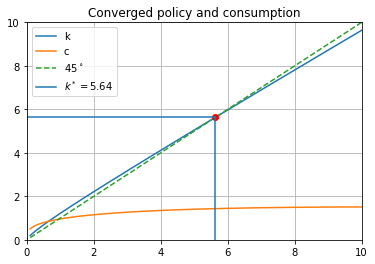

In [21]:
# your code here
# Instantiate OptimalGrowth_EGM
og_EGM = OptimalGrowth_EGM()

# Run solve_model_EGM
y_opt_EGM = solve_model_EGM(og_EGM)

@njit
def equation(k_, k, og, sigma_inv):
    # 𝜎−1(𝑘′𝑖) = 𝑓(𝑘𝑖)+(1−𝛿)𝑘𝑖
    lhs = interp(og.grid, sigma_inv, k_)
    rhs = og.f(k) + (1 - og.delta) * k
    
    return lhs - rhs
    
# Compute the optimal capital
k_opt_EGM = np.zeros_like(og_EGM.grid)

for i, k in enumerate(og_EGM.grid):
    upper = og_EGM.f(k)+(1-og_EGM.delta) * k
    results = brentq(equation, 0, upper, args=(k, og_EGM, y_opt_EGM))
    k_opt_EGM[i] = results[0]

# Compute the optimal consumption
c_opt_EGM = og_EGM.f(k_opt_EGM) + (1-og_EGM.delta) * k_opt_EGM - k_opt_EGM

# Plot the policy and consumption function
plt.figure(figsize=(6,4))
plt.plot(og_EGM.grid, k_opt_EGM, label='k')
plt.plot(og_EGM.grid, c_opt_EGM, label='c')
plt.xlim([0,10])
plt.ylim([0,10])
plt.plot(og_EGM.grid, og_EGM.grid, '--', label=r'$45^\circ$')
plt.title('Converged policy and consumption')

# Compute the steady state capital
idx = np.argwhere(np.diff(np.sign(k_opt_EGM - og_EGM.grid))).flatten()
k_star = og_EGM.grid[idx]
plt.plot(og_EGM.grid[idx], k_opt_EGM[idx], 'ro')
plt.axvline(x=k_star, ymax=k_star/10, label=r"$k^*=%.2f$"%k_star)
plt.axhline(y=k_star, xmax=k_star/10)
plt.legend(fontsize=10)
plt.grid()
plt.show()

From the Euler equation,
$$
\begin{align}
y - k' &= u'^{-1}(\beta u'(y'-\sigma(y'))[f'(k')+1-\delta]\\ 
c &= u'^{-1}(\beta u'(c')[f'(k')+1-\delta]\\
u'(c) &= \beta u'(c')[f'(k')+1-\delta]\\
\end{align}
$$

Since we are looking for a steady state, let $c = c',\ k = k'$

$$
\begin{align}
u'(c) &= \beta u'(c)[f'(k)+1-\delta]\\
1 &= \beta[f'(k)+1-\delta]\\
1 &= \beta[\alpha k^{\alpha-1}+1-\delta]\\
\frac{1}{\beta} &= \alpha k^{\alpha-1}+1-\delta\\
\alpha k^{\alpha-1} &= \frac{1}{\beta}-1+\delta\\
k^{\alpha-1} &= \frac{1}{\alpha}\left(\frac{1}{\beta}-1+\delta\right)\\
k^{-(1-\alpha)} &= \frac{\left(\frac{1}{\beta}-1+\delta\right)}{\alpha}\\
k &= \left(\frac{\left(\frac{1}{\beta}-1+\delta\right)}{\alpha}\right)^{-\frac{1}{(\alpha-1)}}\\
\end{align}
$$


Now we have a closed form solution for k
$$
k^* = \left(\frac{\alpha}{\frac{1}{\beta}-1+\delta}\right)^{\frac{1}{1-\alpha}}
$$

In [22]:
og = og_EGM
(og.alpha/((1/og.beta) - 1 + og.delta))**(1/(1-og.alpha))

5.640537964584442

$$
k^* = \left(\frac{\alpha}{\frac{1}{\beta}-1+\delta}\right)^{\frac{1}{1-\alpha}} \approx 5.64
$$
  
#### Theoretical value of $k^*$ is consistent with the simulated results above.